In [ ]:
%load_ext autoreload
%autoreload 2
import timeit
import numpy as np
import matplotlib.pyplot as plt
from shape import Shape, Block, plot_hulls
from convex_hulls_graph import HullGraph
from shapely.geometry import Point
from multiboat_trajectory_optimization.boat_models import Boat
from multiboat_trajectory_optimization.trajectory_planner import BoatConfigurationPlanning

### Composing Shapes from Blocks

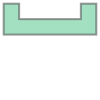

In [54]:
shape_a = Shape([Block(-0.75,0.5,90),Block(0,0.25,0),Block(1,0.25,0),Block(1.75,.5,90)])
shape_b = Block(0,0.25)

shape_a.polygon

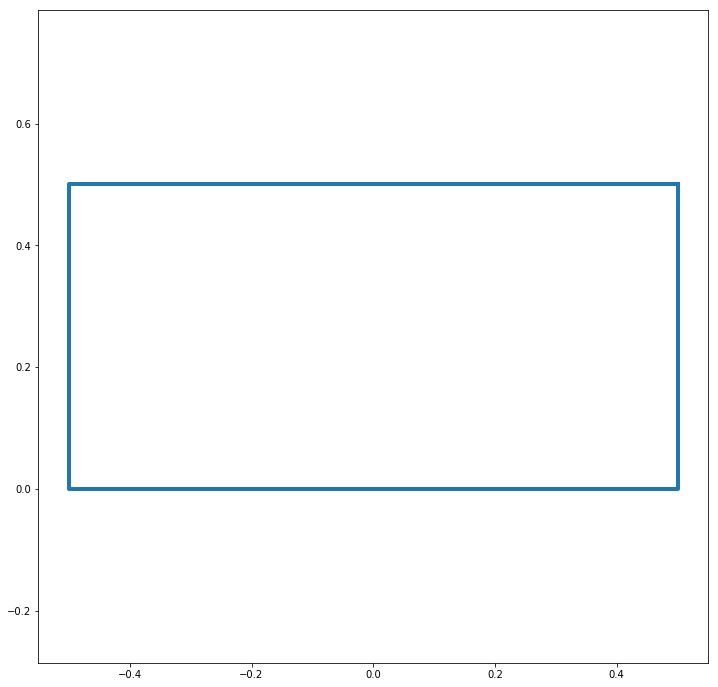

In [3]:
shape_b.plot(union=False)

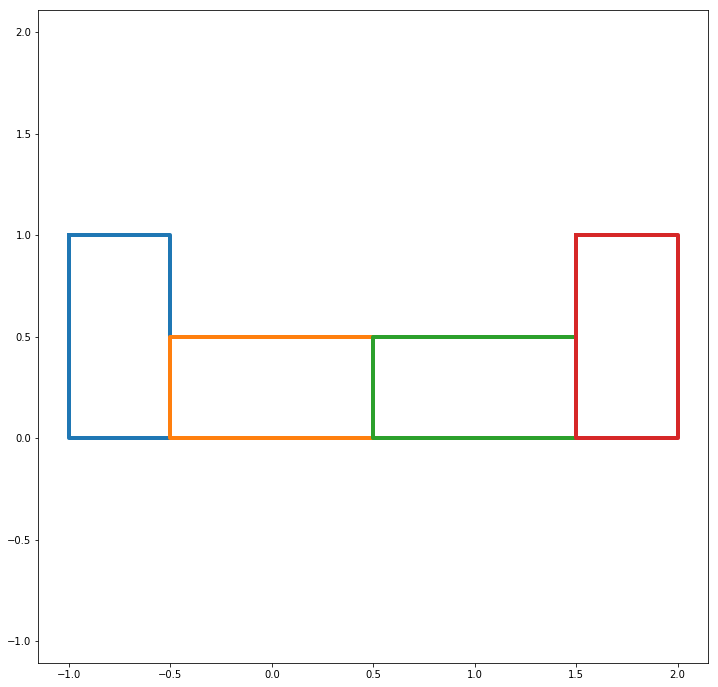

In [4]:
shape_a.plot(union=False)

### Partitioning of convex hulls around shape

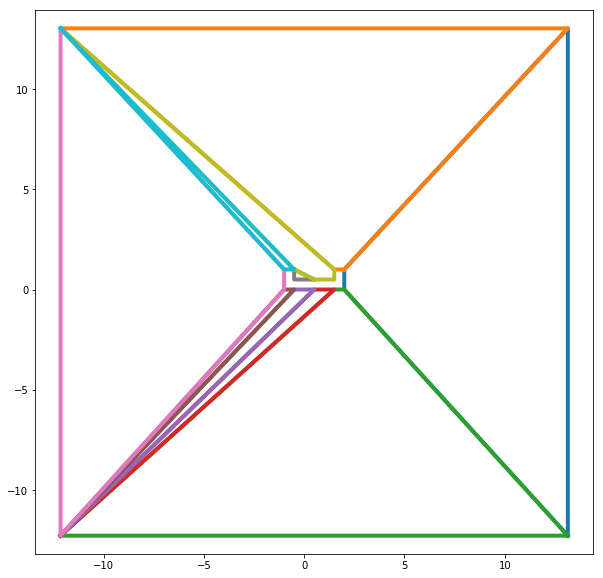

In [5]:
hulls = shape_a.partition_around(buffered=False)

plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

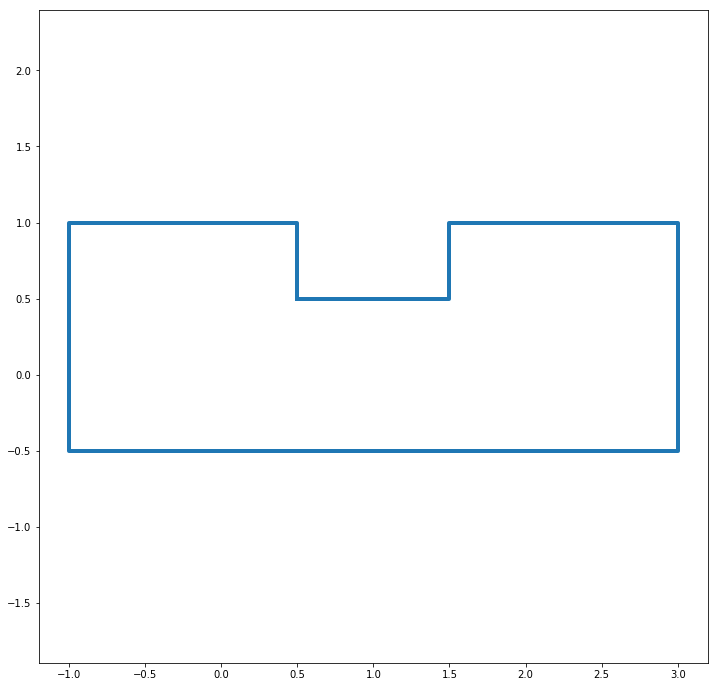

In [6]:
ab = shape_a.c_space(shape_b)
ab.plot(union=True)

### Finding Convex Hull of C-Space

In [46]:
hulls = ab.partition_around(buffered=False)
ab.plot_polygons(hulls)

NameError: name 'ab' is not defined

In [45]:
%load_ext autoreload
%autoreload 2

g = HullGraph(hulls)
g.draw_graph()
plot_hulls(hulls)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'hulls' is not defined

In [275]:
x0 = np.zeros((1, Boat.num_states))
xN = np.zeros((1, Boat.num_states))
x0[0,0] = -1.5
xN[0,0] = 3.5
#xN[0,1] = 1.5
#xN[0,1] = 0.51

In [276]:
from convex_hulls_graph import *
from shape import *
from multiboat_trajectory_optimization.boat_models import *
from multiboat_trajectory_optimization.trajectory_planner import *
from shapely.geometry import Point
import numpy as np

class ShapeBoat(TwoInputBoat, object):
    
    linear=True
    
    def __init__(self, boat_shape, obstacle_shape):
        self.shape = boat_shape
        self.obstacle_shape = obstacle_shape
        self.hulls = self.obstacle_shape.c_space(boat_shape).partition_around(self.shape, buffered=False)
        self.g = HullGraph(self.hulls)
        self.hull_path = None
    
    def toProblemStates(self, boats_S):
        assert len(boats_S)==1
        return super(ShapeBoat, self).toProblemStates(boats_S)
    
    def toGlobalStates(self, boats_S, state_initial=None):
        assert len(boats_S)==1
        return super(ShapeBoat, self).toGlobalStates(boats_S, state_initial)

    def set_end_points(self, x0, xN):
        self.hull_path = self.g.point_path(Point(x0[0,:2]), Point(xN[0,:2])) 

    def hull_constraint(self, h_bool, x, eq, M=10., mp=None):
        val1 = M*(h_bool-1)+eq['b']
        val2 = eq['A'].dot((x).T)
        return mp.add_leq_constraints(val1, val2, linear=True) if mp is not None else val1<=val2
        
    def add_collision_constraints(self, mp, boats_S, M=20.):
        assert len(boats_S)==1
            
        T = len(boats_S[0])
        H = len(self.hull_path) 
        self.in_hull = mp.NewBinaryVariables(T, H, "c")
        
        for t in range(T):
            mp.AddLinearConstraint(np.sum(self.in_hull[t])==1)
            boat_s = boats_S[0][t]
            for i,h in enumerate(self.hull_path):
                
                self.hull_constraint(self.in_hull[t][i],                                       \
                                     boats_S[0,t,:2],                                          \
                                     self.g.vertex_properties["polygon_eq"][self.g.vertex(h)], \
                                     mp=mp                                                     \
                                    )
                #if i>0 and t<T-1:
                #    mp.AddLinearConstraint(self.in_hull[t][i]>=self.in_hull[t+1][i-1])
                
    @classmethod
    def boat_dynamics(cls, s, u):

        derivs = np.zeros_like(s)
        
        derivs[0] = s[2];
        derivs[1] = s[3];
        derivs[2] = u[0]-cls.d11 / cls.m11 * s[2] + u[0] / cls.m11;
        derivs[3] = u[1]-cls.d22 / cls.m22 * s[3] + u[1] / cls.m22;
        return derivs

In [277]:
boat = ShapeBoat(shape_b, shape_a)
boat.set_end_points(x0, xN)

In [278]:
##Check Contains Functions works properly
X = (np.random.rand(100,2)-0.5)*8
for x in X:
    for v in boat.g.vertices():
        assert(
            np.all(boat.hull_constraint(1,x,boat.g.vertex_properties["polygon_eq"][v])) == \
            boat.g.vertex_properties['polygon'][v].contains(Point(x))
              )

In [ ]:
boat = ShapeBoat(shape_b, shape_a)
boat.set_end_points(x0, xN)
planner = BoatConfigurationPlanning(boat)
boats_S, boats_U, time_array, mp, result, solve_time = planner.compute_trajectory(0., 10, x0, xN, time_cost=False, input_cost=True, slack=1e-5, N=100)

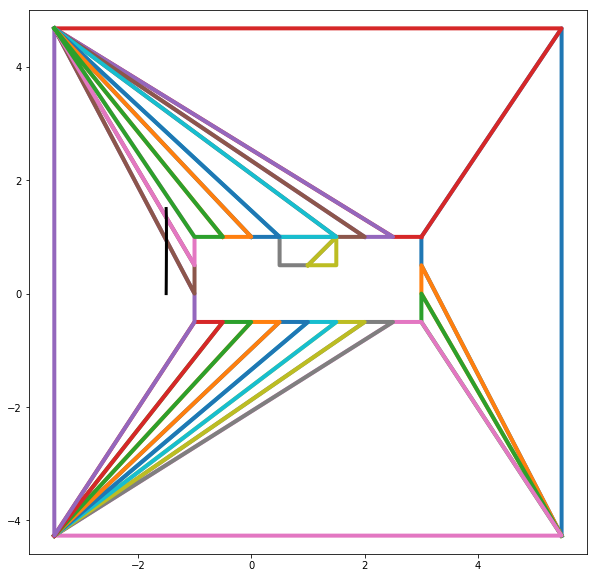

[14, 15, 16]


In [271]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

In [28]:
in_hull = mp.GetSolution(boat.in_hull)

In [32]:
def check(path_hull_i, state_i):
    hull_i = boat.hull_path[path_hull_i]
    print boat.g.vertex_properties['polygon'][boat.g.vertex(hull_i)].contains(Point(boats_S[0,state_i][:2]))
    #print boat.g.vertex_properties['polygon_eq'][boat.g.vertex(hull_i)]
    print boat.contains(0, boats_S[0,state_i,:2], boat.g.vertex_properties['polygon_eq'][boat.g.vertex(hull_i)])

#check(3, 65)
for i,h in enumerate(in_hull):
    print np.array(h,dtype='int')

[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0

In [201]:
def determinant(x, edge_eq):
    dx = x-edge_eq['x1']
    det = edge_eq['dx'][:,0]*dx[:,1]-edge_eq['dx'][:,1]*dx[:,0]
    return det

In [206]:
x1 = np.array([[0,0]])
dx = np.array([[0,-1]])
eq = {'dx': dx, 'x1':x1}

x = np.array([-1,100])

print determinant(x,eq)

[-1]
